In [1]:
import os
from datetime import datetime
from typing import List, Tuple, Dict
from IPython.utils import io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import homogeneity_score, completeness_score

Question 1  
(-1/5, 1.0). emperically calcualated

Question 2

In [3]:
# Load data
path1 = './data/finance_data/Name_sector.csv'
path2 = './data/finance_data/data/'
n_rows = 765 # many files in finance_data/data have 765 rows (+1 for header), we only use these ones
n_files = len(os.listdir(path2))

stock_prices  = []
stock_names   = []
stock_sectors = []
stock_dates   = []
with open(path1, 'r') as name_sector_f:
    line = name_sector_f.readline()
    for f in os.listdir(path2):
        if len(f) > 3 and f[-3:] == 'csv': # skip DS_Store file
            line = name_sector_f.readline()
            n_lines = sum(1 for _ in open(path2 + f))
            if n_lines == n_rows + 1: # +1 for header
                name, sector = line.strip().split(',') # strip() removes \n
                stock_names.append(name)
                stock_sectors.append(sector)
                price = np.genfromtxt(path2 + f, delimiter=',', skip_header=1, usecols=4, dtype=np.float64)
                try:
                    date = np.genfromtxt(path2 + f, delimiter=',', skip_header=1, usecols=0, dtype='datetime64')
                except Exception as e:
                    date = np.genfromtxt(path2 + f, delimiter=',', skip_header=1, usecols=0, dtype=str)
                    date = np.char.replace(date, '/', '-')
                stock_dates.append(date)
                stock_prices.append(price)

stock_prices = np.array(stock_prices)
weekly_inds = np.is_busday(stock_dates[0], weekmask='Mon')
monthly_inds = np.array([x.day for x in stock_dates[0].tolist()]) == 15

In [4]:
class StockGraph:

    def __init__(self, stock_prices: np.ndarray, stock_names: List[str], stock_sectors: List[str]):
        self.stock_prices = stock_prices
        self.stock_names = stock_names
        self.stock_sectors = stock_sectors

        # Calculate values from Question 1
        qi_t = (stock_prices[:, 1:] - stock_prices[:, :-1]) / stock_prices[:, :-1]
        ri_t = np.log(1 + qi_t)
        corr = np.corrcoef(ri_t)
        assert len(corr) == len(stock_prices)

        # Create graph and plot edge weight histogram
        self.edges = np.sqrt(2 * (1 - corr))
        # edges[np.abs(edges) < 1e-2] = 0
        self.G = nx.from_numpy_matrix(self.edges)
        for i in range(len(stock_sectors)):
            self.G.nodes[i]['sector'] = stock_sectors[i]
            self.G.nodes[i]['name'] = stock_names[i]

        self.mst = nx.minimum_spanning_tree(self.G)
        self._pos = nx.kamada_kawai_layout(self.mst)
        
    def plot_edge_weight_histogram(self, title: str = 'Edge Weight Histogram'):
        plt.hist(self.edges.flatten(), bins=100)
        plt.title(title)
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
    
    def _plot_mst(self, colors: np.ndarray, groups_titles: List, legend_title: str, title: str, figsize: Tuple = (11, 11)) -> None:
        """Plots the MST with nodes colored by sector and edges colored by group.

        Parameters
        ----------
        colors : np.ndarray
            Array of colors for each node.
        groups_titles : List
            list of titles of each group used for creating a legend (ie communities or sectors)
        legend_title : str
        title: str
        figsize : Tuple
        """
        if len(groups_titles) < 11:
            cmap = plt.cm.tab10
        elif len(groups_titles) < 21:
            cmap = plt.cm.tab20
        else:
            cmap = plt.cm.magma

        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(self.mst, self._pos, node_size=100, node_color=colors, cmap=cmap)
        nx.draw_networkx_edges(self.mst, self._pos, width=1)
        colors = cmap(np.linspace(0, 1, len(groups_titles)))
        with io.capture_output():
            for i in range(len(groups_titles)):
                plt.scatter([], [], c=colors[i], label=groups_titles[i])
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title=legend_title)
        plt.title(title)
        plt.show()
    
    def plot_mst_sectors(self, title: str = 'Minimum Spanning Tree of Stock Correlation Matrix'):
        self.sectors = tuple(set(stock_sectors))
        self.sector_colors = np.empty(len(self.G.nodes), dtype=np.int64)
        for i, sector1 in enumerate(self.sectors):
            for j, sector2 in enumerate(stock_sectors):
                if sector1 == sector2:
                    self.sector_colors[j] = i

        self._plot_mst(self.sector_colors, self.sectors, 'Sector', title)

    def plot_mst_communities(self, title: str = 'Minimum Spanning Tree of Stock Correlation Matrix'):
        """
        Returns
        -------
        homogeinity_score : float
        completeness_score : float
        """
        # Find and color communities
        communities = nx.algorithms.community.greedy_modularity_communities(self.mst, n_communities=len(self.sectors))
        node_clusters = np.empty(len(self.G.nodes), dtype=np.int64)
        for i in range(len(communities)):
            for j in communities[i]:
                node_clusters[j] = i

        # Plot
        community_titles = [f'Community {i}' for i in range(len(communities))]
        self._plot_mst(node_clusters, community_titles, 'Community', title)
        return (homogeneity_score(self.sector_colors, node_clusters), 
                completeness_score(self.sector_colors, node_clusters))
    
    def calc_alpha(self) -> Tuple[float, float]:
        """For question 4

        Returns
        -------
        alpha1 : float
        alpha2 : float
        """
        sector_counts = {}
        for sector in self.stock_sectors:
            if sector in sector_counts:
                sector_counts[sector] += 1
            else:
                sector_counts[sector] = 1

        alpha1 = 0
        alpha2 = 0
        for i in range(len(self.mst.nodes)):
            N_i = 0
            Q_i = 0
            sector = self.mst.nodes[i]['sector']
            for neighbor in self.mst.neighbors(i):
                if neighbor != i:
                    N_i += 1
                    if stock_sectors[neighbor] == sector:
                        Q_i += 1
            if N_i > 0:
                alpha1 += Q_i / N_i
            alpha2 += sector_counts[sector] / len(self.mst.nodes)
        alpha1 /= len(self.mst.nodes)
        alpha2 /= len(self.mst.nodes)
        return alpha1, alpha2

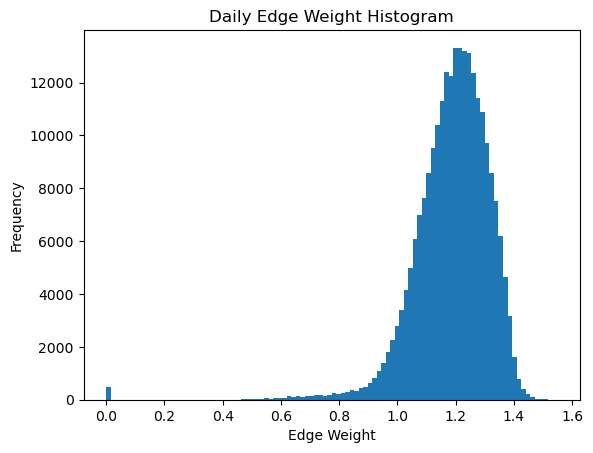

In [5]:
sg = StockGraph(stock_prices, stock_names, stock_sectors)
sg.plot_edge_weight_histogram('Daily Edge Weight Histogram')

Question 3

The MST shows a few cor sectors that all sectors are related to (financials, industrials, and to a limited extent consumer discretionary). Other sectors such as utilities or energy are very independent of other sectors. The pattern makes sense since sectors like energy and real estate being linked make natural sense. Moreover financials track much of the economy and make sense to be linked with many sectors

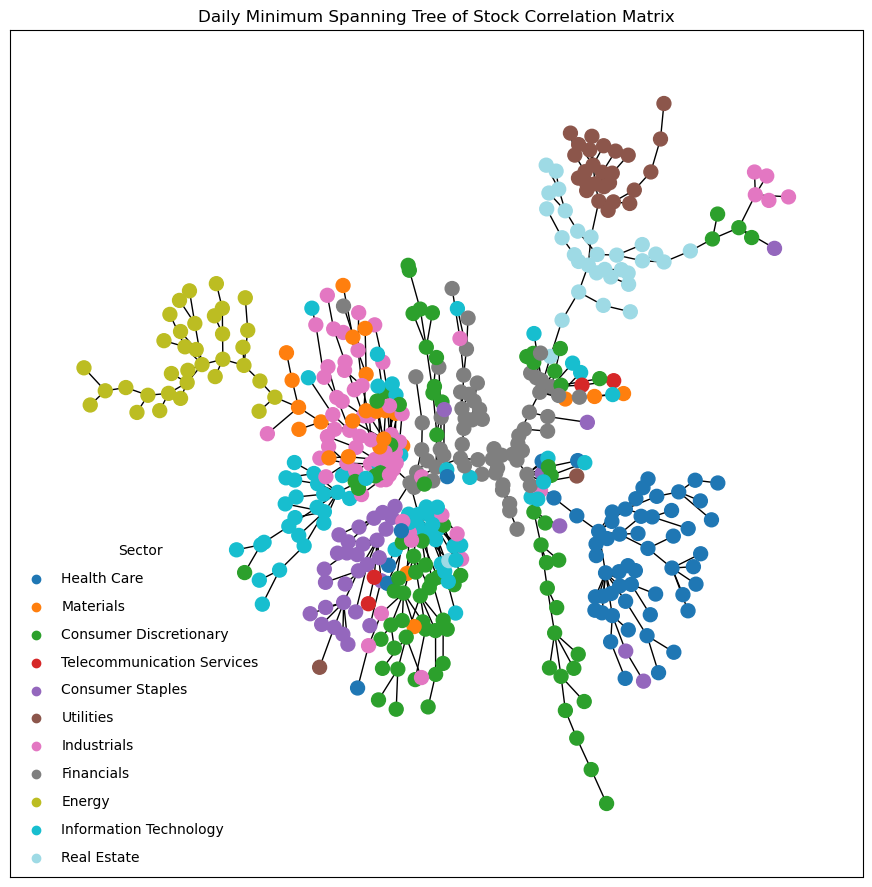

In [10]:
sg.plot_mst_sectors('Daily Minimum Spanning Tree of Stock Correlation Matrix')

Question 4

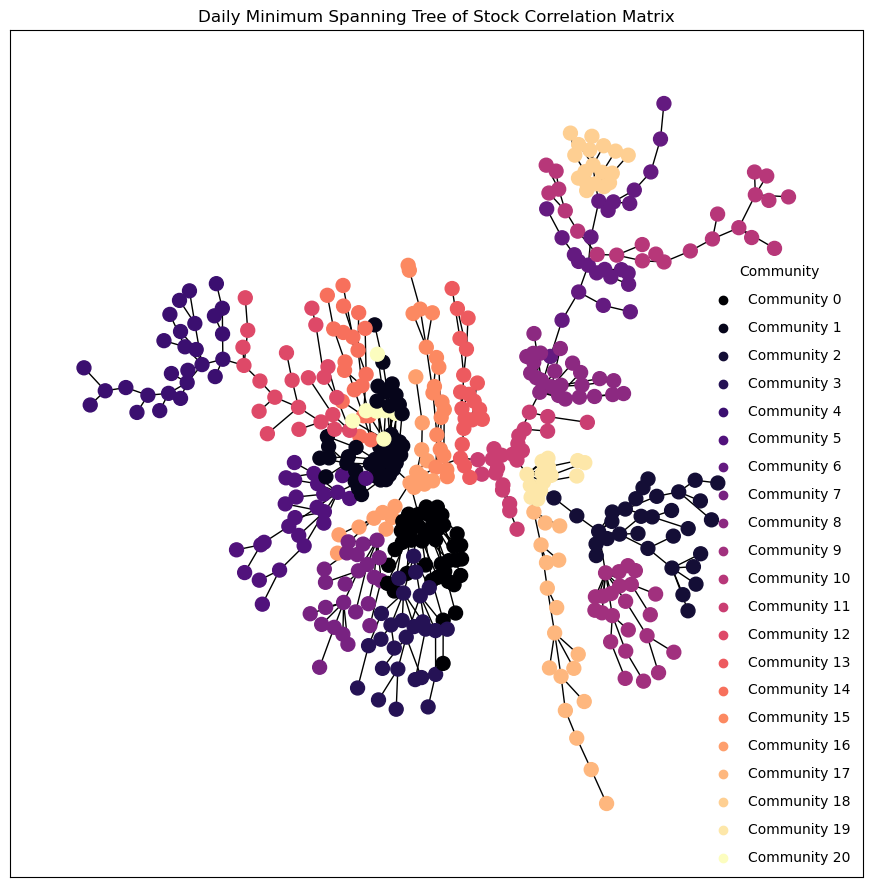

(0.6840535603130569, 0.5153251900845165)

In [11]:
sg.plot_mst_communities('Daily Minimum Spanning Tree of Stock Correlation Matrix')

Question 5

the first approach actually uses the clustering we can visually obeserve from the MST plot, while the second alpha value gives a baseline value using random picking   
alpha1 = 0.83  
alpha2 = 0.11

In [17]:
print(sg.calc_alpha())

(0.8289300775306759, 0.11418807061253222)


Question 6

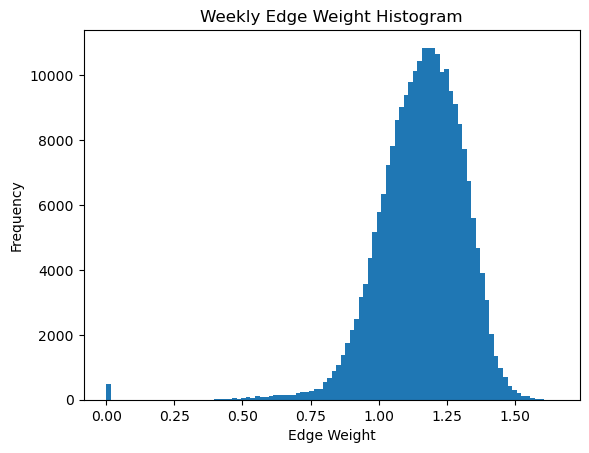

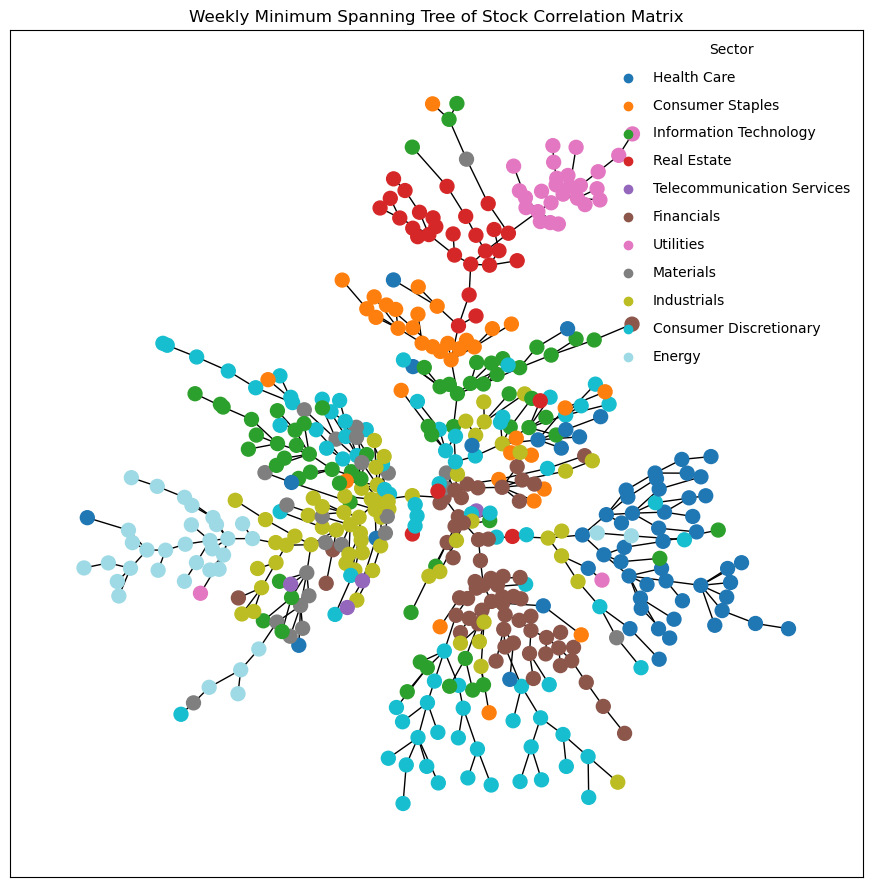

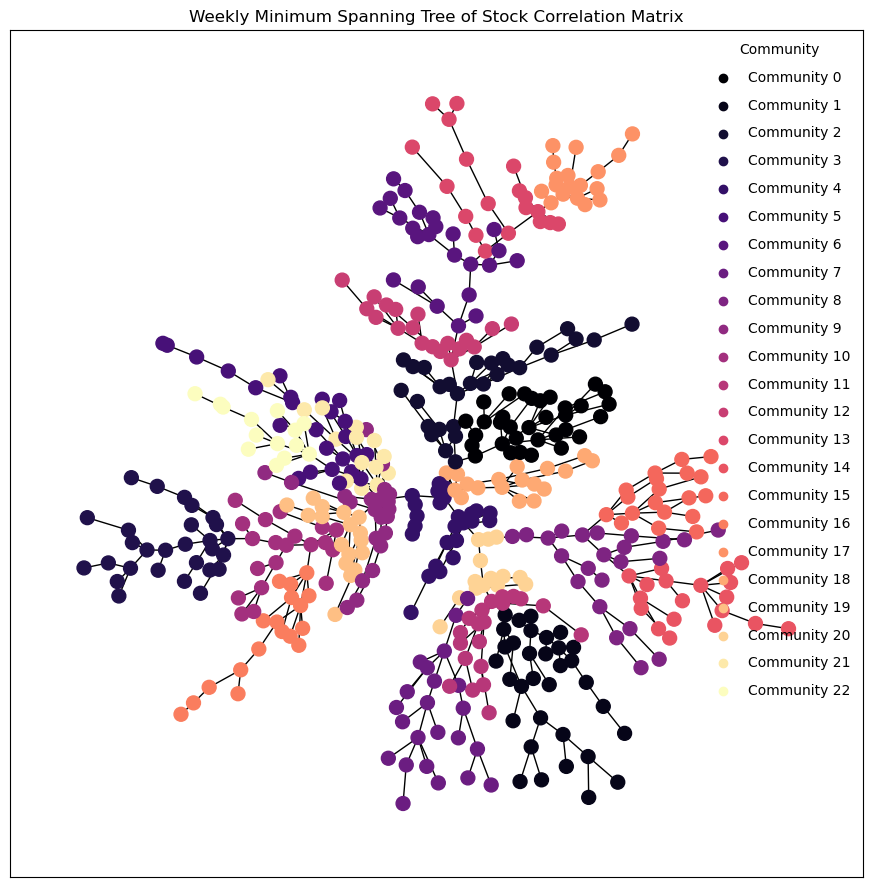

(0.7429696034959192, 0.11418807061253222)


In [7]:
# stock_prices[:, weekly_inds]
# stock_prices[:, monthly_inds]
sg = StockGraph(stock_prices[:, weekly_inds], stock_names, stock_sectors)
sg.plot_edge_weight_histogram('Weekly Edge Weight Histogram')
sg.plot_mst_sectors('Weekly Minimum Spanning Tree of Stock Correlation Matrix')
sg.plot_mst_communities('Weekly Minimum Spanning Tree of Stock Correlation Matrix')
print(sg.calc_alpha())

Question 7

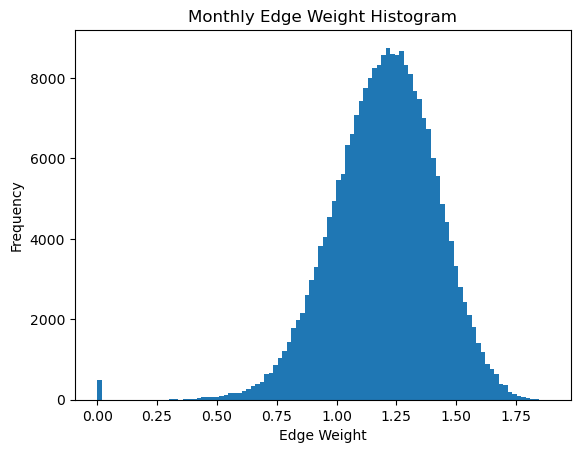

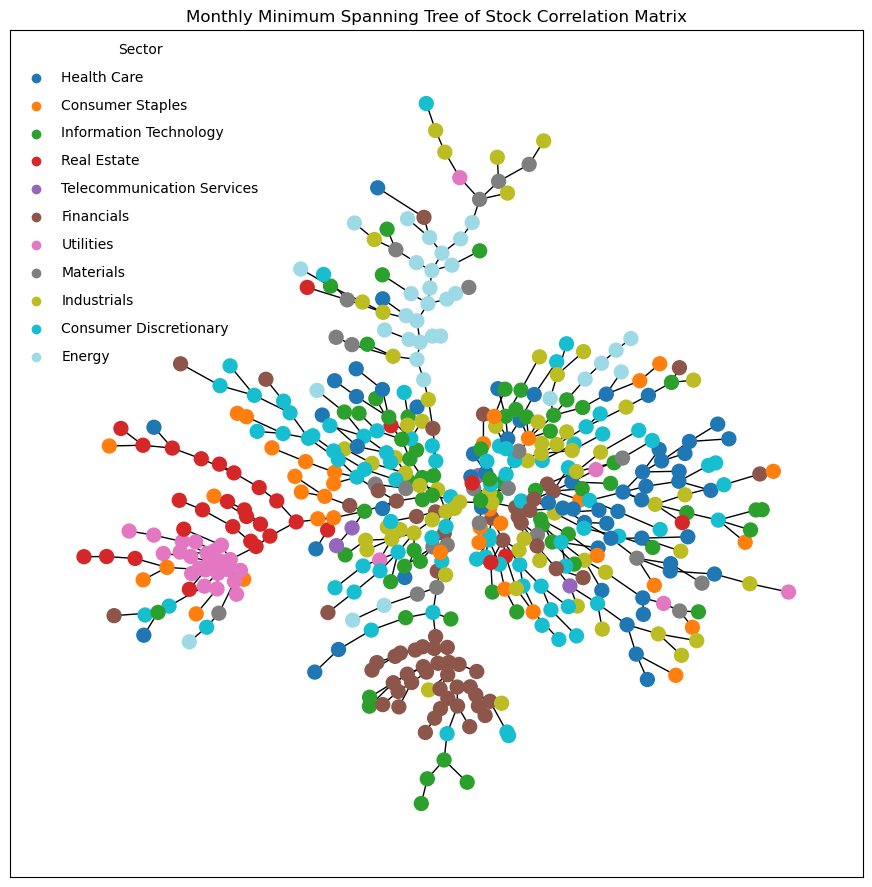

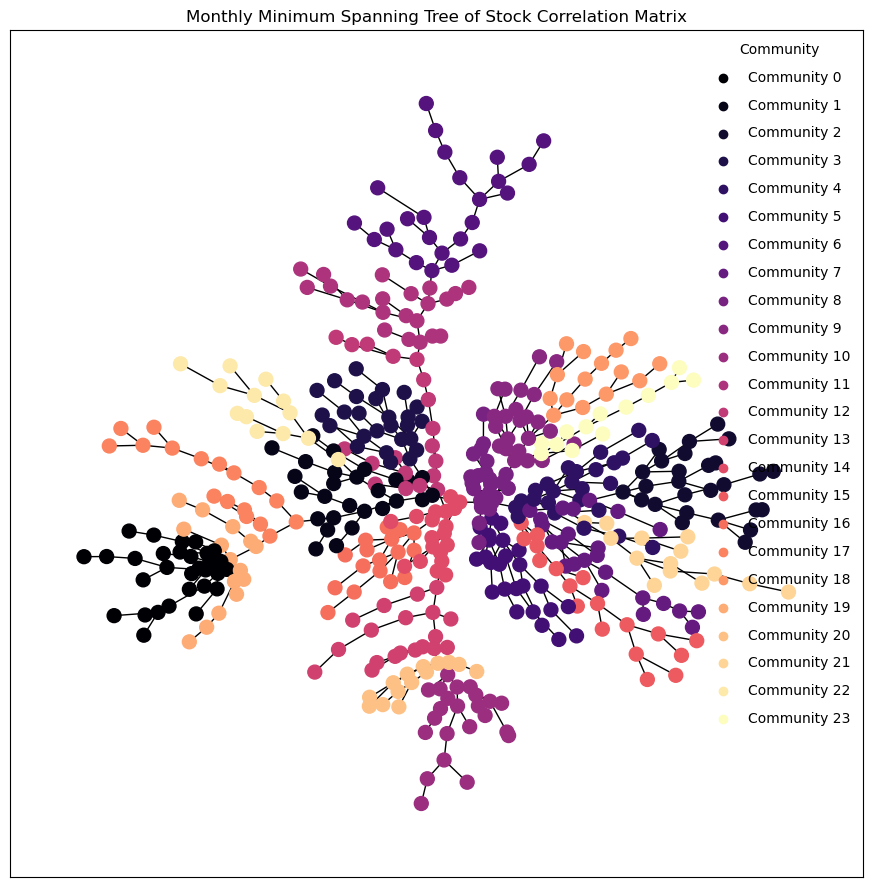

(0.48346828609986486, 0.11418807061253222)


In [8]:
sg = StockGraph(stock_prices[:, monthly_inds], stock_names, stock_sectors)
sg.plot_edge_weight_histogram('Monthly Edge Weight Histogram')
sg.plot_mst_sectors('Monthly Minimum Spanning Tree of Stock Correlation Matrix')
sg.plot_mst_communities('Monthly Minimum Spanning Tree of Stock Correlation Matrix')
print(sg.calc_alpha())

Question 8  

Edge weights grow slightly higher in value from daily to weekly to monthly and the spread (standard deviation) increases as well. The MST also features less visibble clustering . when sectors are colored than in daily (weekly and monthly perform worse). The cluster MST also shows worse grouping in the weekly and worst in the monthly case. This is further backed up by the degrading alpha value of 0.8 to 0.7 to 0.5 from daily to weekly to monthly.